# Making Predictions of Gas Prices from ARIMA

In [32]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import datetime


from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tools.plotting import autocorrelation_plot

## Data Wrangling

In [19]:
#parsing and renaming columns
file = pd.ExcelFile("future_gas_folder/data/GAS.xls")
df_gas= file.parse('Data 1', header=2, ncolumns=2) 
df_gas = df_gas[['Date', 'Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']]
df_gas = df_gas.rename(index=str,
    columns={"Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)": "gas_price"})

#dropping NaNs and convert to datetime
df_gas.dropna(axis=0, inplace=True)
df_gas['Date'] = pd.to_datetime(df_gas.Date)
df_gas.set_index('Date',  inplace=True)

In [22]:
#sanity checking

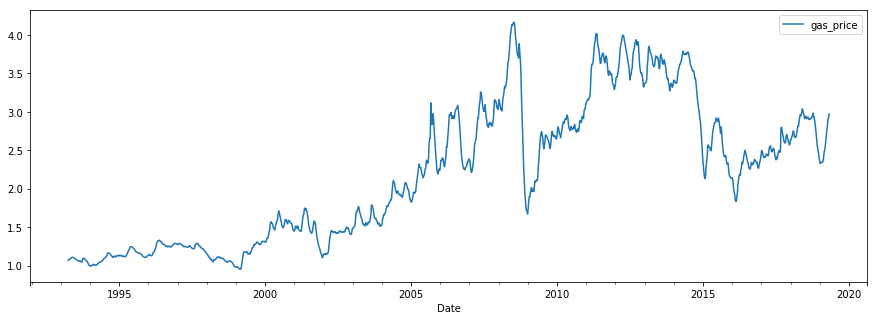

In [27]:
df_gas.plot(figsize = (15, 5))

## Manual Parameter Selection

### Order of Differencing (d)

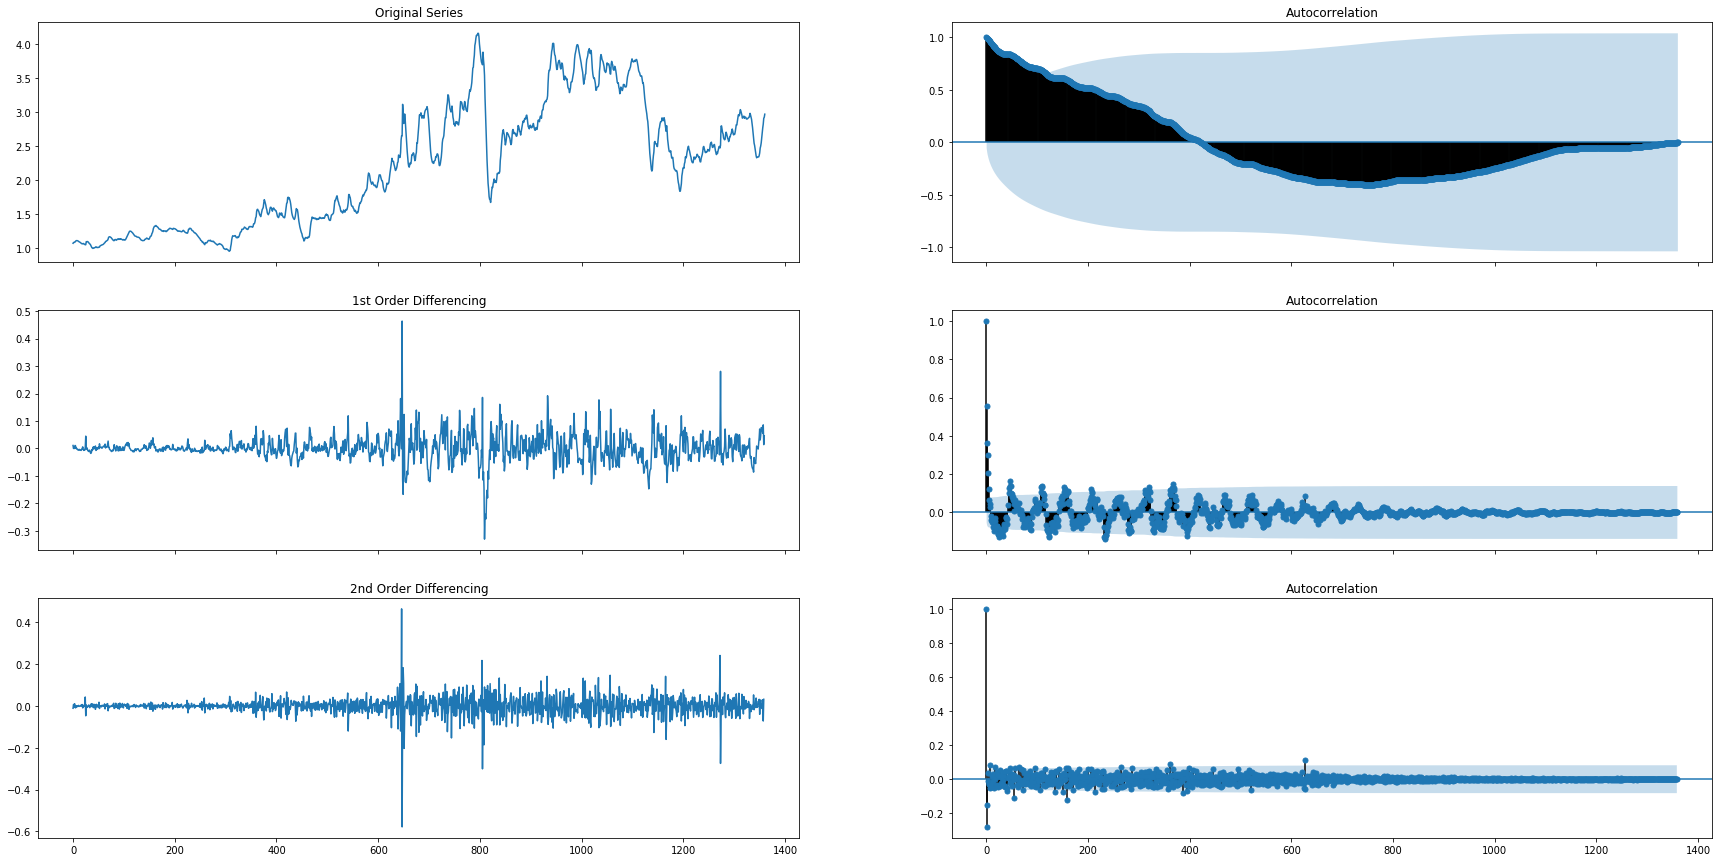

In [56]:
fig, axes = plt.subplots(3, 2, figsize = (30,15), sharex=True)
axes[0, 0].plot(df_gas.values); axes[0, 0].set_title('Original Series')
plot_acf(df_gas.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(df_gas.values, axis = 0)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(df_gas.values, axis = 0), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(df_gas.values, axis = 0), axis = 0)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(df_gas.values, axis = 0), axis = 0), ax=axes[2, 1])

plt.show()

In [62]:
adf_dif0 = adfuller(df_gas['gas_price'])
print('ADF Statistic: %f' % adf_dif0[0], 'p-value: %f' % adf_dif0[1])
adf_dif1 = adfuller(np.diff(df_gas['gas_price'], axis = 0))
print('ADF Statistic: %f' % adf_dif1[0], 'p-value: %f' % adf_dif1[1])
adf_dif2 = adfuller(np.diff(np.diff(df_gas['gas_price'], axis = 0),axis = 0))
print('ADF Statistic: %f' % adf_dif2[0], 'p-value: %f' % adf_dif2[1])

ADF Statistic: -2.056594 p-value: 0.262322
ADF Statistic: -10.797902 p-value: 0.000000
ADF Statistic: -12.242284 p-value: 0.000000


We do an ad-fuller test to determine whether the series is stationary, based on above, 1st order differencing is more than enough.

### Number of lags in the AR model (p)

We plot the PACF of the 1st-differenced prices to see how well lagged observations explain variations in the data

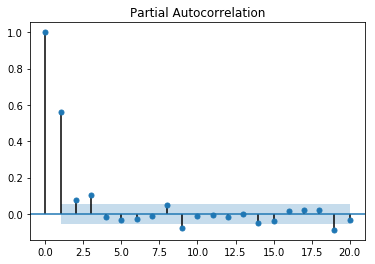

In [70]:
plot_pacf(np.diff(df_gas['gas_price'], axis = 0), lags = 20);

We can see from this plot that lags 1, 2, 3 , and 4 are significantly above the 95% confidence interval.

### Number of lagged errors in the MA model (q)

We plot ACF to see how well lagged errors explain variations in the data

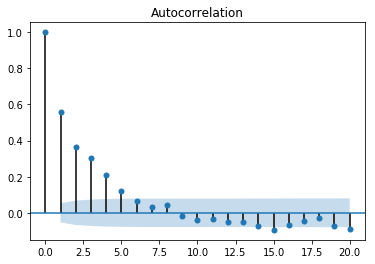

In [92]:
plot_acf(np.diff(df_gas['gas_price'], axis = 0), lags = 20);

## Fitting

In [130]:
order = np.array([2,1,1])
model = ARIMA(df_gas, order=order)
model_fit = model.fit()
print(model_fit.summary())

/home/allen/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/home/allen/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.gas_price   No. Observations:                 1360
Model:                 ARIMA(2, 1, 1)   Log Likelihood                2470.672
Method:                       css-mle   S.D. of innovations              0.039
Date:                Mon, 20 May 2019   AIC                          -4931.344
Time:                        12:26:27   BIC                          -4905.268
Sample:                    04-12-1993   HQIC                         -4921.582
                         - 04-29-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0015      0.003      0.520      0.603      -0.004       0.007
ar.L1.D.gas_price     0.9368      0.139      6.760      0.000       0.665       1.208
ar.L2.D.gas_price    -0.

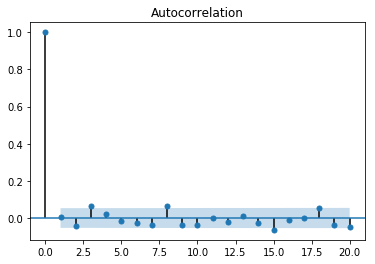

In [131]:
residuals = pd.DataFrame(model_fit.resid)
plot_acf(residuals, lags = 20);

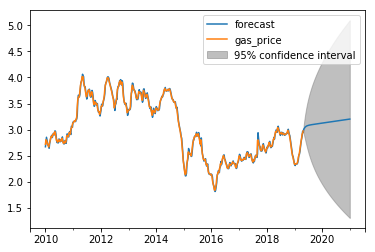

In [137]:
#plt.figure(figsize=(20,10))
model_fit.plot_predict('2010', '2021', dynamic=False)
plt.show()

### Automatic Parameter Selection